# ML para predecir el gesto

Creación y evaluación de modelos de Machine Learning para predecir qué gesto está realizando el paciente

In [1]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, LeaveOneGroupOut

## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LearningCurveDisplay
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV

## Seleccion de variables
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFECV # recursive

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../csvFiles/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,Duration,HipAngleLeft_standardDeviation,RightArmAngle_standardDeviation,KneeAngleLeft_standardDeviation,AnkleAngleLeft_standardDeviation,...,ElbowAngleRight_Kurtosis,LeftArmAngle_Kurtosis,ShoulderAngleRight_Kurtosis,WristAngleLeft_Kurtosis,ElbowAngleLeft_Kurtosis,WristAngleRight_Kurtosis,ShoulderAngleLeft_Kurtosis,HipAngleRight_Kurtosis,ArmsTogetherAngle_Kurtosis,AnkleAngleRight_Kurtosis
0,101,0,1,1,stand,59,0.3608677355979031,2.7655574767746303,0.20870629032593843,0.6581472034160547,...,-1.5096047609935206,0.5374402120462101,0.24725567691914474,-1.1548519667455222,-0.9176895137907444,0.19853266525825441,-0.6351422949522179,-0.9240468871850966,-0.6043028159859238,-0.40440680981149635
1,101,0,2,1,stand,44,0.11857848631771781,2.2982802008603884,0.22148909073910306,0.8313514219454735,...,-1.280617105642371,0.7268055218978855,-1.7517830977424425,-0.7701703570143632,0.4187723636318532,1.0481449056142007,-0.9030033089456406,-0.19860783889835965,0.8934212147732565,-0.276497605679932
2,101,0,3,1,stand,53,0.24619052972163322,3.445303563459787,0.20016295285928792,0.9602665690153961,...,-1.4552465068519256,0.1405061114156383,0.7198891878500557,-0.5806536048592652,-0.76127983523148,-0.3931234568509234,0.412760624339358,-1.007601590228747,-0.4138693928861996,-0.5305323879118911
3,101,0,4,1,stand,57,0.28321350295077613,3.626021938955907,0.3449046585971368,0.5731684465708434,...,-1.51459552588099,1.0602340465863236,0.4958653590427531,-0.13640312363512264,-0.5844906010216535,-0.6109341257432597,-1.3306916169093075,-1.4875437672995169,-1.2588076707533085,-0.057357413926721
4,101,0,5,1,stand,60,0.39363598833851376,3.767306517718122,0.2176579492233252,0.6589984240898876,...,-1.3601464899179059,-1.527706279445947,0.39390720825161907,-0.42688443195923,-0.5349520236928611,-1.1701446029912246,-0.8445014311637222,-1.4273439546363045,-0.33874666284848587,-0.32227339359147944


In [3]:
test_result = pd.DataFrame({'classifier': ['K-Neighbors',
                                            'Decision tree',
                                            'Naive Bayes',
                                            'Suport Vector Machine',
                                            'Random Forest']})


## 1. Preprocesado

### 1.1 Codificar variables

In [4]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

### 1.2 Dividir el dataset

In [5]:
# # Dividimos los datos en varibales independientes y en target
# X = df.drop(['GestureLabel'], axis = 1)
# y = pd.DataFrame(df['GestureLabel'])

# # Dividimos en train y test
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y)    

# # Convertimos los df de target (y) a 1-d
# train_y = train_y.values.ravel()
# test_y = test_y.values.ravel()


In [6]:
# dejar dos pacientes como test

test_df = df.loc[(df.SubjectID==101) | (df.SubjectID==105) | (df.SubjectID==201) | (df.SubjectID==202) | (df.SubjectID==301) | (df.SubjectID==302)]
train_df = df.loc[(df.SubjectID!=101) & (df.SubjectID!=105) & (df.SubjectID!=201) & (df.SubjectID!=202) & (df.SubjectID!=301) & (df.SubjectID!=302)] 

train_X = train_df.drop(['GestureLabel'], axis=1)
train_y=pd.DataFrame(train_df['GestureLabel']) 
test_X= test_df.drop(['GestureLabel'], axis=1) 
test_y =pd.DataFrame(test_df['GestureLabel'])

# # Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()

In [7]:
test_df

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,Duration,HipAngleLeft_standardDeviation,RightArmAngle_standardDeviation,KneeAngleLeft_standardDeviation,AnkleAngleLeft_standardDeviation,...,ElbowAngleRight_Kurtosis,LeftArmAngle_Kurtosis,ShoulderAngleRight_Kurtosis,WristAngleLeft_Kurtosis,ElbowAngleLeft_Kurtosis,WristAngleRight_Kurtosis,ShoulderAngleLeft_Kurtosis,HipAngleRight_Kurtosis,ArmsTogetherAngle_Kurtosis,AnkleAngleRight_Kurtosis
0,101,0,1,1,4.0,59,0.360868,2.765557,0.208706,0.658147,...,-1.509605,0.537440,0.247256,-1.154852,-0.917690,0.198533,-0.635142,-0.924047,-0.604303,-0.404407
1,101,0,2,1,4.0,44,0.118578,2.298280,0.221489,0.831351,...,-1.280617,0.726806,-1.751783,-0.770170,0.418772,1.048145,-0.903003,-0.198608,0.893421,-0.276498
2,101,0,3,1,4.0,53,0.246191,3.445304,0.200163,0.960267,...,-1.455247,0.140506,0.719889,-0.580654,-0.761280,-0.393123,0.412761,-1.007602,-0.413869,-0.530532
3,101,0,4,1,4.0,57,0.283214,3.626022,0.344905,0.573168,...,-1.514596,1.060234,0.495865,-0.136403,-0.584491,-0.610934,-1.330692,-1.487544,-1.258808,-0.057357
4,101,0,5,1,4.0,60,0.393636,3.767307,0.217658,0.658998,...,-1.360146,-1.527706,0.393907,-0.426884,-0.534952,-1.170145,-0.844501,-1.427344,-0.338747,-0.322273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,302,8,8,1,4.0,52,11.424405,0.990962,2.603929,9.983740,...,-0.791581,-0.807044,-0.224533,12.196447,-0.793706,-1.098567,-0.366280,-1.433769,-0.406934,-1.617788
2111,302,8,9,1,4.0,38,9.589612,1.037077,2.467788,18.074198,...,-0.886800,-1.430416,-1.127259,5.506816,-0.426975,-0.263049,-1.664634,-1.555810,-1.177196,-0.408288
2112,302,8,10,1,4.0,71,11.553039,1.724850,1.767761,13.772852,...,0.989915,-1.383455,-0.221273,-1.415198,-1.175774,-0.573888,-1.422455,-1.722551,-1.297706,-1.722055
2113,302,8,11,1,4.0,46,9.767917,1.080478,5.861215,13.566125,...,0.069990,-0.877415,-0.052745,20.928583,1.037932,-0.450344,-0.246652,-0.100138,-0.838194,-1.086973


## 2. Modelos de ML
Se ha creado una función para entrenar y evaluar los modelos

In [8]:
#-------Funcion para evaluar los modelos-----------
def test_models(modelos, tX, ty, df, column_name):
   new_evaluation = []
   for modelo in modelos:
      prediction = modelo.predict(tX) #  predicciones en los datos de prueba
      report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
      score = f1_score(test_y, prediction, average='weighted', zero_division=0) 
      new_evaluation.append(score)
      print(f"\nModelo: {modelo.__class__.__name__}") 
      print(report) 
   df.loc[:, column_name] = new_evaluation



In [9]:
#-----------Función matriz de confusión-----
def plot_confusion_matrix(modelo, tX, ty, ax=None):
    """
    Grafica la matriz de confusión para un modelo dado.

    Parámetros:
    * modelo: El modelo de clasificación entrenado.
    * tX: Los datos de prueba.
    * ty: Los valores reales del target para los datos de prueba.
    """

    prediction = modelo.predict(tX)
    cm = confusion_matrix(ty, prediction)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", ax=ax)
    ax.set_title('Confusion Matrix ' + modelo.__class__.__name__)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')


In [10]:
knn = KNeighborsClassifier() # K-Neighbors classifier
dtree = DecisionTreeClassifier() # Decision tree
nb = GaussianNB() # Naive Bayes
svm = SVC() # Suport Vector Machine
rf = RandomForestClassifier()  # Random Forest

models = [knn, dtree, nb, svm, rf]

for modelo in models:
    modelo.fit(train_X, train_y) # entrenamos el modelo



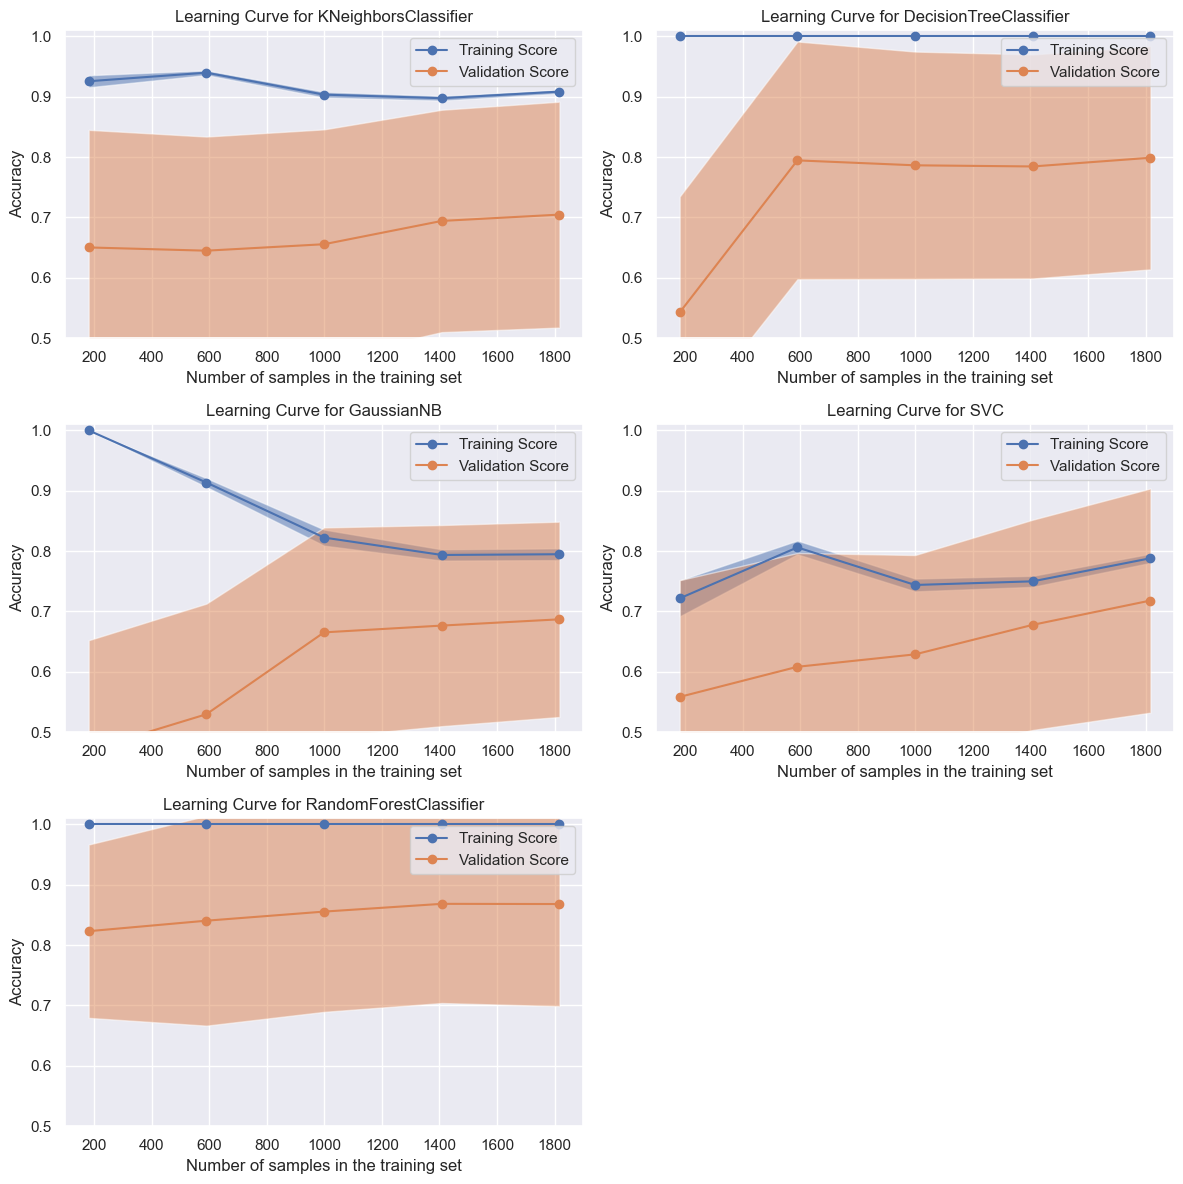

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

common_params = {
    "X": train_X,
    "y": train_y,
    "groups": train_X['SubjectID'],
    # "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": LeaveOneGroupOut(),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
for idx, estimator in enumerate(models):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training Score", "Validation Score"])
    ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")
    ax.set_ylim(0.5, 1.01)
fig.delaxes(axes.flatten()[5])

plt.tight_layout()
plt.show()

In [12]:
# entrenamiento + evaluación
test_models(models, test_X, test_y, test_result, 'modelos')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        58
           1       0.75      0.85      0.79        66
           2       0.58      0.64      0.61        95
           3       0.62      0.64      0.63        69
           4       0.77      0.36      0.49        94
           5       0.50      0.58      0.54        55
           6       0.94      0.86      0.90        58
           7       0.74      0.69      0.71        72
           8       0.74      0.85      0.79        95

    accuracy                           0.69       662
   macro avg       0.71      0.71      0.70       662
weighted avg       0.71      0.69      0.69       662


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        58
           1       0.89      0.74      0.81        66
           2       0.68      0.60      0.64        95
           3    

## 3. Hipermetrización

In [13]:
#-------------Parametros---------------
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9]}

param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

param_grid_rf = {
    'n_estimators': [5, 10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}


Modelo: KNeighborsClassifier
Best parameters:  {'n_neighbors': 7}
Best score:  0.7161518392229717


<Figure size 600x400 with 0 Axes>

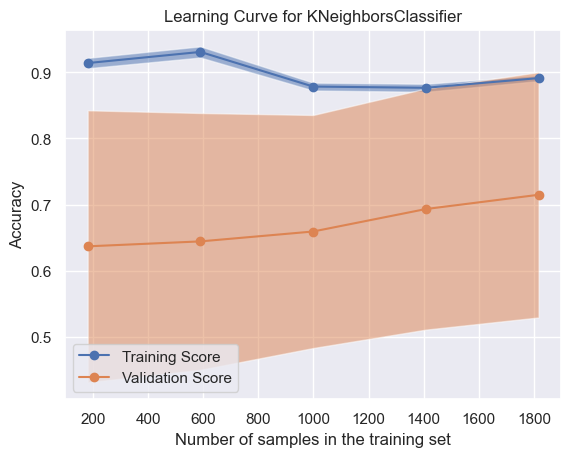


Modelo: DecisionTreeClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 10}
Best score:  0.8263584717231728


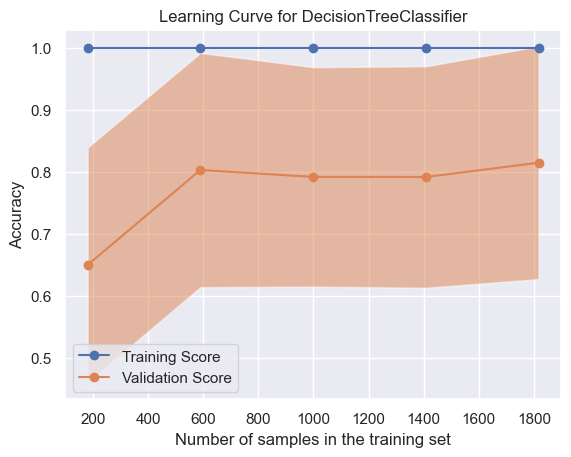


Modelo: GaussianNB
Best parameters:  {'var_smoothing': 3.5111917342151275e-06}
Best score:  0.690261775886526


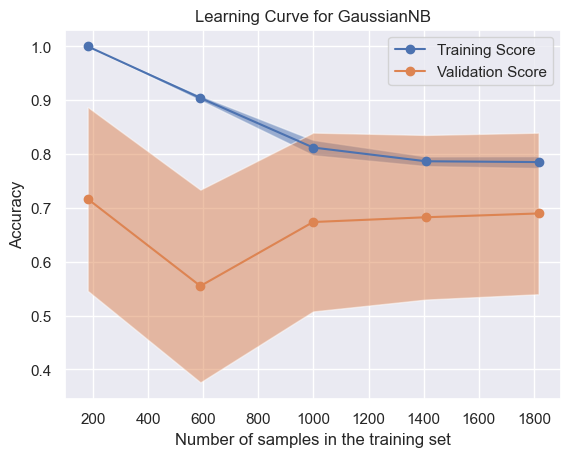


Modelo: SVC
Best parameters:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best score:  0.8339482513095188


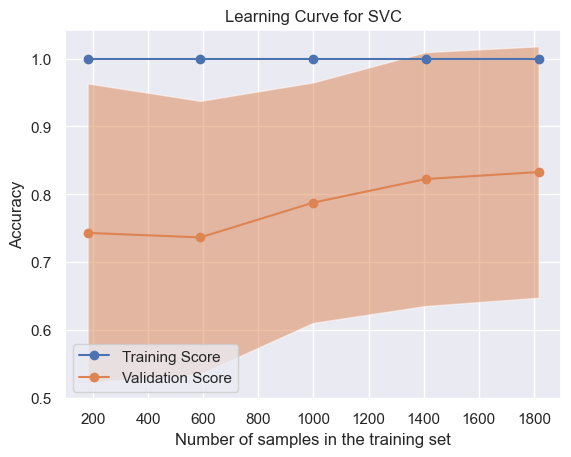

In [14]:
def aplicar_hiperparametrizacion(X, y):
    logo = LeaveOneGroupOut()
    gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=logo, scoring='accuracy', )
    gs_dtree = GridSearchCV(DecisionTreeClassifier(), param_grid_dtree, cv=logo, scoring='accuracy')
    gs_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=logo, scoring='accuracy')
    gs_svm = GridSearchCV(SVC(), param_grid_svm, cv=logo, scoring='accuracy')
    gs_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=logo, scoring='accuracy')

    subject_ids = X['SubjectID']
    
    modelos = [gs_knn, gs_dtree, gs_nb, gs_svm, gs_rf]

    best_models = []
    for modelo in modelos:
        modelo.fit(X, y, groups=subject_ids)
        best_modelo = modelo.best_estimator_
        print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
        print("Best parameters: ", modelo.best_params_)
        print("Best score: ", modelo.best_score_)
        best_models.append(best_modelo)
        LearningCurveDisplay.from_estimator(best_modelo, 
                                            X=X,
                                            y=y,
                                            groups=subject_ids,
                                            cv=logo,
                                            score_type="both",
                                            n_jobs=4,
                                            line_kw={"marker": "o"},
                                            std_display_style="fill_between",
                                            score_name="Accuracy"
                                        )
        plt.legend(["Training Score", "Validation Score"])
        plt.title(f"Learning Curve for {modelo.estimator.__class__.__name__}")
        plt.show()

    return best_models
    
plt.figure(figsize=(6,4))

best_models = aplicar_hiperparametrizacion(train_X, train_y)

In [ ]:
test_models(best_models, test_X, test_y, test_result, 'hiperparametros')

In [ ]:
#-----------matriz de confusión-----
num_models = len(best_models)
num_cols = 2  # Number of matrices per row
num_rows = (num_models + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))


for i, modelo in enumerate(best_models):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    plot_confusion_matrix(modelo, test_X, test_y, ax=ax)
    # Hide unused subplots
for i in range(num_models, num_rows * num_cols):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

## 4. Feature Selection

### 4.1 SelectKBest

In [ ]:
# Definimos feature Selection K=50 (selecciona entonces las 50 variables que considere mas importantes)
feature_selection=SelectKBest(k=25)

# Fit Feature Selection (entrena y hace una tranfosmada)
feature_selection.fit_transform(train_X, train_y)

# Selecionamos las características mas relevantes para nuestro problema
selected = feature_selection.get_support(indices=True)
print(train_X.columns[selected])

### 4.2 Entrenar con las variables sleccionadas

In [ ]:
# creación de los modelos
knn_fs = KNeighborsClassifier() # K-Neighbors classifier
dtree_fs = DecisionTreeClassifier() # Decision tree
nb_fs = GaussianNB() # Naive Bayes
svm_fs = SVC() # Suport Vector Machine
rf_fs = RandomForestClassifier()  # Random Forest

models_fs = [knn_fs, dtree_fs, nb_fs, svm_fs, rf_fs]


In [ ]:
# Reduce train_X to the selected features with .transform(X)
#creamos un data frame vacio para hacer una tabla donde esten 
# las variables con la trsnformada de la X.
# esto elimina las variales que no nos intersan.

X_fs = pd.DataFrame(feature_selection.transform(train_X),
                 columns=train_X.columns[selected])

for modelo in models_fs:
        print(f"\nModelo: {modelo.__class__.__name__}")
        modelo.fit(X_fs, train_y, groups=X_fs['SubjectID'])
        scores = cross_val_score(modelo, X_fs, train_y, scoring='accuracy', cv=LeaveOneGroupOut())
        print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


In [ ]:
X_fs_test = pd.DataFrame(feature_selection.transform(test_X),
                 columns=test_X.columns[selected])
test_models(models_fs, X_fs_test, test_y, test_result, 'FS')

In [ ]:
for modelo in best_models:
    modelo.fit(X_fs, train_y)
test_models(best_models, X_fs_test, test_y, test_result, 'H+Fs')

### 4.3 Recursive feature elimination

In [ ]:
dtree_rfe = DecisionTreeClassifier() # Decision tree
rf_rfe = RandomForestClassifier(n_estimators = 5)  # Random Forest

models_with_coef = [dtree_rfe, rf_rfe]

In [ ]:
def seleccion_variables(models, X, y):
    for model in models:
        rfecv = RFECV(
            estimator=model,
            scoring="accuracy",
            n_jobs=2 # Number of cores to run in parallel while fitting across folds. 
        )
        rfecv.fit(X, y)
        print(f"\nModelo: {rfecv.estimator.__class__.__name__}") 
        print(f"Optimal number of features: {rfecv.n_features_}")
        selected = rfecv.get_feature_names_out()
        print(selected)
        print(rfecv.score)
        cv_results = pd.DataFrame(rfecv.cv_results_)
        plt.title(f"RFECV {rfecv.estimator.__class__.__name__}")
        plt.xlabel("Number Of Features")
        plt.ylabel("Accuracy")
        plt.plot(range(1, len(cv_results['mean_test_score']) + 1), cv_results['mean_test_score'])
        plt.show()

seleccion_variables(models_with_coef, train_X, train_y)

# Evaluación modelos

In [ ]:
test_result

In [ ]:
# Melt the dataframe to transform it into long format
df_melted = pd.melt(test_result, id_vars=['classifier'], value_vars=['modelos', 'hiperparametros', 'FS', 'H+Fs'],
                    var_name='score_type', value_name='score')

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.lineplot(x='score_type', y='score', hue='classifier', data=df_melted, marker='o', palette='Set1')

# Set labels and title
plt.xlabel('Score Type')
plt.ylabel('Score')
plt.title('Scores by Classifier')
plt.ylim(0,1)

# Display the plot
plt.xticks()
plt.grid(True)
plt.tight_layout()
plt.show()